<a href="https://colab.research.google.com/github/Ryan-Shaik/Computer_Vision/blob/index.edit/Cats_vs_Dogs_Classifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

### Get Kaggles Cats vs Dogs Dataset

In [ ]:
!unzip -q /content/drive/MyDrive/dogs-vs-cats.zip -d /content/
!unzip -q /content/test1.zip -d /content/
!unzip -q /content/train.zip -d /content/

In [ ]:
# Set directory path for files
train_dir = "./train"
test_dir = "./test1"

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [ ]:
print(f"Number of images in {train_dir} is {len(train_files)}")
print(f"Number of images in {test_dir} is {len(test_files)}")

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [ ]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.11957.jpg


**Create Transforms**

In [ ]:
transformations = transforms.Compose([
    transforms.Resize((60,60)),
    transforms.ToTensor()
])

### Create a Dataset class that stores dataset information (paths, labels and transformations)

In [ ]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


In [ ]:
# Create train and test datset object
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

In [ ]:
train.__getitem__(0)

(tensor([[[0.0902, 0.0784, 0.0863,  ..., 0.2941, 0.3098, 0.3882],
          [0.1137, 0.1059, 0.1059,  ..., 0.2902, 0.2980, 0.3843],
          [0.1569, 0.1529, 0.1373,  ..., 0.2824, 0.2863, 0.3686],
          ...,
          [0.7098, 0.7294, 0.7451,  ..., 0.6431, 0.5922, 0.6235],
          [0.6902, 0.7059, 0.7294,  ..., 0.6745, 0.6667, 0.6157],
          [0.6824, 0.6902, 0.7137,  ..., 0.6863, 0.7725, 0.7451]],
 
         [[0.0078, 0.0039, 0.0078,  ..., 0.2078, 0.2157, 0.2980],
          [0.0196, 0.0157, 0.0118,  ..., 0.2039, 0.2039, 0.2941],
          [0.0471, 0.0431, 0.0314,  ..., 0.1961, 0.1882, 0.2745],
          ...,
          [0.8000, 0.8196, 0.8314,  ..., 0.5137, 0.4941, 0.5255],
          [0.7882, 0.8039, 0.8275,  ..., 0.5529, 0.5608, 0.5059],
          [0.7843, 0.7922, 0.8157,  ..., 0.5686, 0.6588, 0.6353]],
 
         [[0.0157, 0.0078, 0.0118,  ..., 0.1098, 0.1137, 0.2039],
          [0.0157, 0.0118, 0.0078,  ..., 0.1098, 0.1059, 0.2078],
          [0.0235, 0.0196, 0.0078,  ...,

In [ ]:
# Get the shape of a single image
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


### Using datset object to create tran, validation split

In [ ]:
train, val = torch.utils.data.random_split(train, [20000, 5000])

In [ ]:
print(len(train))
print(len(val))

20000
5000


In [ ]:
# Create an array of our label
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val))]

<Axes: ylabel='count'>

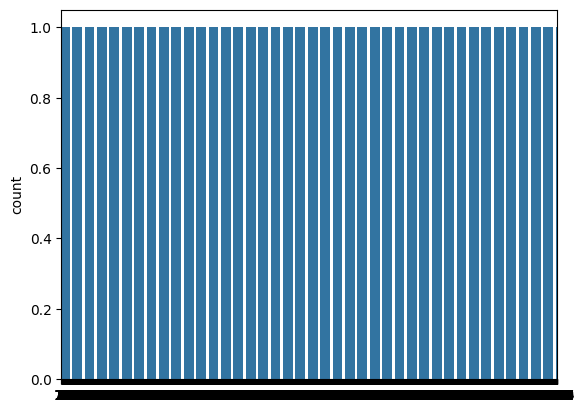

In [ ]:
import seaborn as sns
sns.countplot(val_set_class_count)

### Dataloaders

In [ ]:
train_dataset = torch.utils.data.DataLoader(train, batch_size=32, shuffle = True)
val_dataset = torch.utils.data.DataLoader(val, batch_size= 32, shuffle = False)

### View sample images

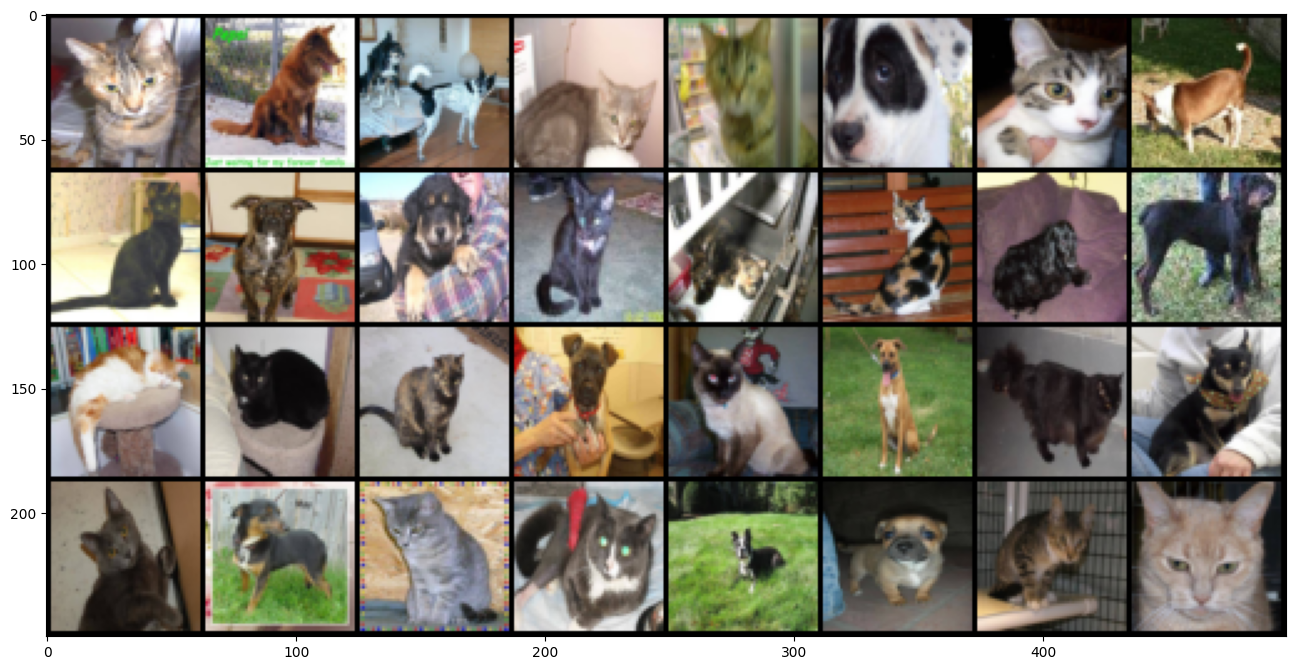

In [ ]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize =(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
np_grid_images = grid_imgs.numpy()

# in tensor image is (batch, width, height), for matplotlib transpose it to (width, height, batch)
plt.imshow(np.transpose(np_grid_images, (1,2,0)));

### Build Model

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*5*5, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()


        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 2)
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim = 1)

In [ ]:
model = CNN()
model.to(device)
summary(model, (3,60, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 512]         819,712
             ReLU-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
             ReLU-14                  [

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
epochs=10

### Train Model

**We use TQDM to perform keras style training**

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    with tqdm(train_dataset, unit= "batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{epochs}")

        for data, label in tepoch:
            data,label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch : {epoch +1} | Training Accuracy = {correct/total}')
        print(f'Epoch {epoch + 1} | Training Loss =  {train_running_loss/len(train_dataset)}')

    # Get validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        with torch.inference_mode():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = loss_fn(val_output, val_label)

                val_running_loss += loss_val.item() * val_data.size(0)
                _, val_pred = torch.max(val_output, dim=1)
                total += val_label.size(0)
                correct += (val_pred == val_label).sum().item()
            val_accuracy.append(correct/total)
            val_loss.append(val_running_loss/len(val_dataset))
            print(f'Epoch : {epoch +1} | Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch + 1} | Validation Loss =  {val_running_loss/len(val_dataset)}')




<ipython-input-26-a6b8d199324e>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit= "batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 1 | Training Accuracy = 0.7683
Epoch 1 | Training Loss =  0.5298818018436432
Epoch : 1 | Validation Accuracy = 0.7672
Epoch 1 | Validation Loss =  16.883948017837135


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 2 | Training Accuracy = 0.78565
Epoch 2 | Training Loss =  0.5154816005706787
Epoch : 2 | Validation Accuracy = 0.788
Epoch 2 | Validation Loss =  16.40934203992224


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 3 | Training Accuracy = 0.79785
Epoch 3 | Training Loss =  0.504073002576828
Epoch : 3 | Validation Accuracy = 0.7936
Epoch 3 | Validation Loss =  16.15255682179882


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 4 | Training Accuracy = 0.80875
Epoch 4 | Training Loss =  0.4951905169487
Epoch : 4 | Validation Accuracy = 0.7996
Epoch 4 | Validation Loss =  15.993467262596083


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 5 | Training Accuracy = 0.82275
Epoch 5 | Training Loss =  0.48319690175056457
Epoch : 5 | Validation Accuracy = 0.7958
Epoch 5 | Validation Loss =  16.05144720472348


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 6 | Training Accuracy = 0.82895
Epoch 6 | Training Loss =  0.47568473858833316
Epoch : 6 | Validation Accuracy = 0.8066
Epoch 6 | Validation Loss =  15.778747771196304


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 7 | Training Accuracy = 0.83745
Epoch 7 | Training Loss =  0.46805416226387025
Epoch : 7 | Validation Accuracy = 0.8094
Epoch 7 | Validation Loss =  15.734672470457236


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 8 | Training Accuracy = 0.8544
Epoch 8 | Training Loss =  0.4537058150291443
Epoch : 8 | Validation Accuracy = 0.7996
Epoch 8 | Validation Loss =  15.990728498264483


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 9 | Training Accuracy = 0.86635
Epoch 9 | Training Loss =  0.44340160999298095
Epoch : 9 | Validation Accuracy = 0.8102
Epoch 9 | Validation Loss =  15.657864884965738


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch : 10 | Training Accuracy = 0.8759
Epoch 10 | Training Loss =  0.43422850546836855
Epoch : 10 | Validation Accuracy = 0.8108
Epoch 10 | Validation Loss =  15.630136875589942


In [ ]:
train_loss

[0.5298818018436432,
 0.5154816005706787,
 0.504073002576828,
 0.4951905169487,
 0.48319690175056457,
 0.47568473858833316,
 0.46805416226387025,
 0.4537058150291443,
 0.44340160999298095,
 0.43422850546836855]

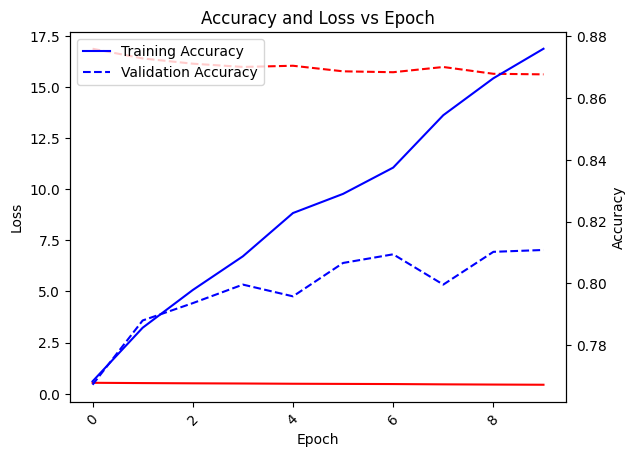

In [ ]:
epoch_log = [*range(epochs)]

fig, ax1 = plt.subplots()

plt.title("Accuracy and Loss vs Epoch")
plt.xticks(rotation = 45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, train_loss, "r-", label = "Training Loss")
ax2.plot(epoch_log, train_accuracy, "b-", label = "Training Accuracy")

ax1.plot(epoch_log, val_loss, "r--", label = "Validation Loss")
ax2.plot(epoch_log, val_accuracy, "b--", label = "Validation Accuracy")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
plt.legend()

In [ ]:
PATH = "./cats_vs_dogs_10_epochs.pth"
torch.save(model.state_dict(),PATH)

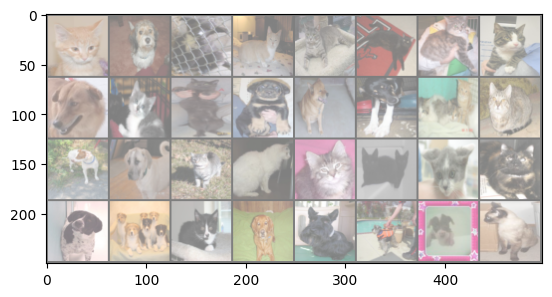

GroundTruth:  tensor(0) tensor(1) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(1) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(1) tensor(1) tensor(0) tensor(1) tensor(1) tensor(1) tensor(1) tensor(0)


In [ ]:
# function to show image
def imshow(img):
    img = img/ 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(val_dataset)
images,labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%1s' % labels[j] for j in range(32)))

In [ ]:
model = CNN()
model.to(device)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

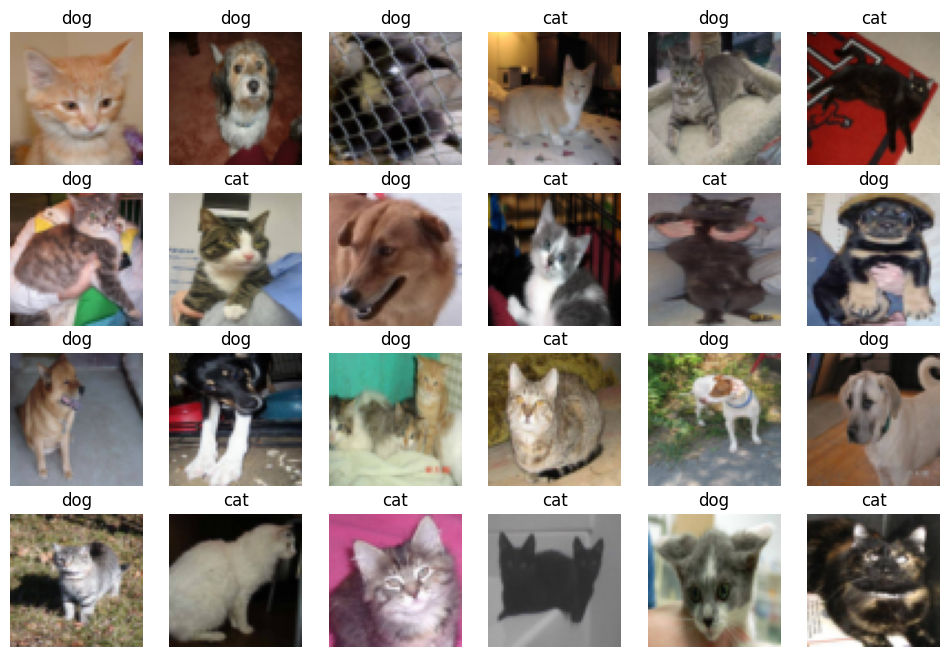

In [ ]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize = (12,8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim = 1)
pred = [p.item() for p in pred]
ad =  {0: "cat", 1: "dog"}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis(False)
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))